In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
import numpy as np


def load_csv(filePath, sep=','):
    return pd.read_csv(filePath, sep=sep)

def engineer_features(df):
    df = df.copy()
    # Age in years
    df['age_years'] = df['age'] // 365
    # BMI
    df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
    # Pulse pressure
    df['pulse_pressure'] = df['bp_high'] - df['bp_low']
    # Hypertension flag
    df['is_hypertensive'] = ((df['bp_high'] >= 140) | (df['bp_low'] >= 90)).astype(int)
    # Combined metabolic risk
    df['risk_level'] = df['cholesterol'] + df['glucose_level']
    # Drop raw columns used to create features
    df.drop(columns=[
        'age', 'height', 'weight', 'bp_high', 'bp_low', 'cholesterol', 'glucose_level'
    ], inplace=True)
    return df

def split_features_target(df, yColumn, dropColumns):
    X = df.drop(columns=dropColumns + [yColumn])
    y = df[yColumn]
    return X, y

def apply_polynomial(X, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    columns = poly.get_feature_names_out(X.columns if isinstance(X, pd.DataFrame) else None)
    return pd.DataFrame(X_poly, columns=columns)

def apply_scaling(X, exclude=[]):
    scaler = MinMaxScaler()

    # Separate excluded columns
    X_excluded = X[exclude]
    
    # Drop excluded columns and scale the rest
    X_dropped = X.drop(columns=exclude)
    X_scaled = scaler.fit_transform(X_dropped)
    
    # Create DataFrame from scaled data
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_dropped.columns, index=X.index)
    
    # Concatenate scaled and excluded columns
    X_combined = pd.concat([X_scaled_df, X_excluded], axis=1)

    # Optional: preserve original column order
    X_combined = X_combined[X.columns]

    return X_combined

def split_data(X, y, test_size=0.4, cv_size=0.5, seed=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=cv_size, random_state=seed)
    return X_train, y_train, X_cv, y_cv, X_test, y_test

def prepare_data(filePath, 
                 yColumn, 
                 csv_sep=',',
                 scale=True,
                 polynomial=False,
                 polyDegree=2,
                 dropColumns=['id'],
                 exclude_scaling=[]):

    df = load_csv(filePath, sep=csv_sep)

    # Apply feature engineering
    # df = engineer_features(df)

    # Drop duplicate drops (prevent appending yColumn every call)
    dropCols = list(dropColumns)  # copy list to avoid side effects
    if yColumn not in dropCols:
        dropCols.append(yColumn)

    X, y = split_features_target(df, yColumn, dropCols)

    if polynomial:
        X = apply_polynomial(X, degree=polyDegree)

    if scale:
        X = apply_scaling(X,exclude_scaling)

    return split_data(X, y)


def train_model(X, y, w=None, epochs = 100):
    model = LogisticRegressionCV(max_iter=epochs,
                             solver='lbfgs', 
                             penalty='l2',
                            #  Cs=[0.001, 0.01, 0.1, 1, 10],
                             random_state=52,
                             n_jobs=2, 
                             class_weight='balanced')
    model.fit(X,y, w)

    print('Max Iterations:', epochs)
    print('Training Score: ',model.score(X, y))
    print('Training Cs: ',model.Cs_)
    print('Total Iterations',model.n_iter_)    
    

    return model


def predict_plot(model, X, y, plottingSample = None, predictionLine=True, dotsWithPridction=False):
    y_hats = model.predict(X)

    print('Training Score: ',model.score(X, y))
    print('Training Cs: ',model.Cs_)
    
    if(plottingSample == None):
        plottingSample = len(y_hats)

    plt.scatter(range(plottingSample), y[:plottingSample], label='True Y')
    if dotsWithPridction:
        plt.scatter(range(plottingSample), y_hats[:plottingSample],color='red' )
    if predictionLine:
        plt.plot(range(plottingSample), y_hats[:plottingSample], label='Predicted Y (Line)', color='green')
        
    plt.title('Prediction vs True Values')
    plt.xlabel('Index')
    plt.ylabel('Y Value')
    # plt.legend()
    plt.show()

def combine_datasets(X1, y1, X2, y2):
     X = np.concatenate((X1, X2), axis=0)
     y = np.concatenate((y1, y2), axis=0)
     
     return X,y


In [12]:
dsPath = '../data/unzipped-data/logistic_regression_for_housing_100k.csv'
yColumn  = 'Will_Buy'

X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_data(dsPath,
                                                            yColumn,
                                                            dropColumns=['Customer_ID'],
                                                            polynomial=True,
                                                            polyDegree=5,
                                                            exclude_scaling=['Owns_Home', 'Previous_Purchase'])
X = X_train
y = y_train
# X, y = combine_datasets(X, y, X_test, y_test)
# X, y = combine_datasets(X, y, X_cv, y_cv)

model = train_model(X, y ,epochs=200000)


Max Iterations: 200000
Training Score:  0.9988166666666667
Training Cs:  [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Total Iterations [[[11 15 17 25 38 23  0 21  0  0]
  [11 15 18 28 22 17 28  0  0  0]
  [11 15 17 27 35 23  6  0  0  0]
  [11 15 17 26 24 20 25  0  0  0]
  [11 15 18 28 26 21 20  0  0  0]]]


Training Score:  0.9988166666666667
Training Cs:  [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


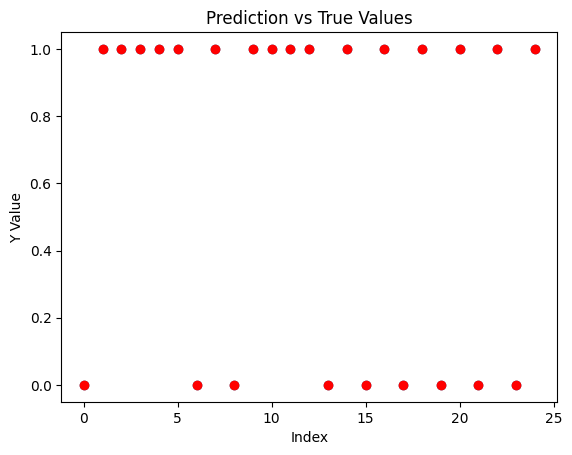

Training Score:  0.9986
Training Cs:  [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


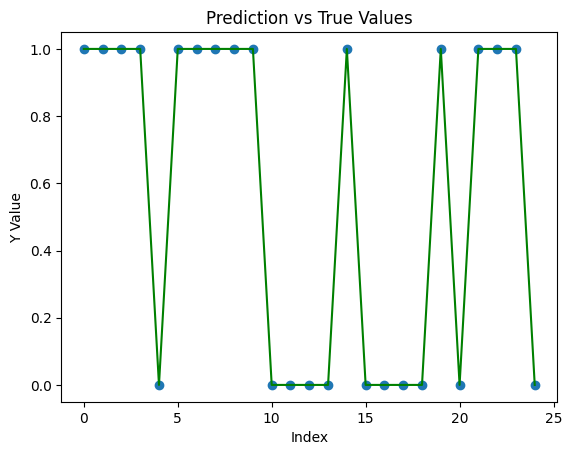

Training Score:  0.99845
Training Cs:  [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


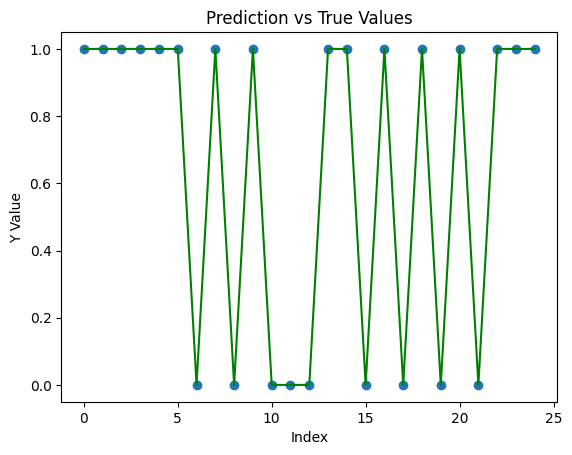

In [14]:
predict_plot(model, X_train, y_train, predictionLine=False, dotsWithPridction=True, plottingSample=25)

predict_plot(model, X_cv, y_cv, predictionLine=True,dotsWithPridction=False, plottingSample=25)

predict_plot(model, X_test, y_test, predictionLine=True,dotsWithPridction=False, plottingSample=25)